IMPORTING ALL THE NECCESSARY MODULES

In [62]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from textblob import TextBlob

[nltk_data] Downloading package punkt to C:\Users\Vivek
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Vivek
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Vivek
[nltk_data]     gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading the datasets of the four companies Oneplus,Apple,Vivo and Samsung on which we will perform EDA to see the problems the companies are facing .

In [63]:
Oneplus =pd.read_csv("Oneplus.csv")
Iphone=pd.read_csv("Iphone.csv")
Samsung=pd.read_csv("Samsung.csv")
Vivo=pd.read_csv('Vivo.csv')

Adding Company column to all the DataFrames before we merge into main DataFrame.

In [64]:
Iphone['Company']='Apple'
Iphone

,Name,Title,Rating,Comment,Company
0,Neha,\n\n\n\n\n\n\n\n \n \n Do not buy iphone ...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Please do ...,Apple
1,shanu Kumar,\n\n\n\n\n\n\n\n \n \n Solid premium phon...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Awesome Ph...,Apple
2,Sunny Kumar,\n\n\n\n\n\n\n\n \n \n First Time iPhone ...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n The iPhone...,Apple
3,Krusshna,\n\n\n\n\n\n\n\n \n \n Don’t buy it from ...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Bought the...,Apple
4,Amazon Customer,\n\n\n\n\n\n\n\n \n \n Worst Experience E...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n My Phone i...,Apple
...,...,...,...,...,...
1485,Pratik,\n\n\n\n\n\n\n\n \n \n Iphone 11 love\n \n,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Iphone 11 ...,Apple
1486,shivansenthil,\n\n\n\n\n\n\n\n \n \n Awesome\n \n,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Good\n\n \n,Apple
1487,Manoj K.,\n\n\n\n\n\n\n\n \n \n Nice Phone\n \n,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Nice phone...,Apple
1488,Hussain,\n\n\n\n\n\n\n\n \n \n Damaged product\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Received a...,Apple


In [65]:
Oneplus['Company']='Oneplus'
Oneplus

,Name,Title,Rating,Comment,Company
0,Abhishek Agarwal,\n\n\n\n\n\n\n\n \n \n Bad bad camera\n \n,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n It's not v...,Oneplus
1,Kiran KS,\n\n\n\n\n\n\n\n \n \n The original segme...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Battery us...,Oneplus
2,Aman More,\n\n\n\n\n\n\n\n \n \n A good daily drive...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Pros:1) Cl...,Oneplus
3,Nikhil,\n\n\n\n\n\n\n\n \n \n *Read before you b...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Yea..pre-o...,Oneplus
4,Jackie Thakkar,\n\n\n\n\n\n\n\n \n \n Bad phone\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Not value ...,Oneplus
...,...,...,...,...,...
1455,!,\n\n\n\n\n\n\n\n \n \n Best phone of 2020...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Bloody goo...,Oneplus
1456,Souvik,\n\n\n\n\n\n\n\n \n \n One of the best ov...,5.0 out of 5 stars,"\n\n\n\n\n\n\n\n\n\n \n \n \n Well , it ...",Oneplus
1457,User123,\n\n\n\n\n\n\n\n \n \n Calls issue. Defec...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Calls not ...,Oneplus
1458,Rajkannu nataraj,\n\n\n\n\n\n\n\n \n \n Worth of product\n...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Awesome pr...,Oneplus


In [66]:
Samsung['Company']='Samsung'
Samsung

,Name,Title,Rating,Comment,Company
0,J.G.Krishnaa,\n\n\n\n\n\n\n\n \n \n HONEST M31s. HONES...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Honest rev...,Samsung
1,Ysak,\n\n\n\n\n\n\n\n \n \n Jack of all trades...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Ordered on...,Samsung
2,Sneha Jaiswal Singla,\n\n\n\n\n\n\n\n \n \n The phone got dead...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This is t...,Samsung
3,Narasimha,\n\n\n\n\n\n\n\n \n \n Disappointed compl...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Strongly r...,Samsung
4,Amazon Customer,\n\n\n\n\n\n\n\n \n \n Screen blacked out...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n purchased ...,Samsung
...,...,...,...,...,...
1455,mayuri madhusudan mandhane,\n\n\n\n\n\n\n\n \n \n More than Worth at...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Great phon...,Samsung
1456,Amazon Customer,\n\n\n\n\n\n\n\n \n \n I would recommend ...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n The batter...,Samsung
1457,Vijay S.,"\n\n\n\n\n\n\n\n \n \n Great Phone, Value...",5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Ordered on...,Samsung
1458,Salil Varma,\n\n\n\n\n\n\n\n \n \n Battery life is no...,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Placement ...,Samsung


In [67]:
Vivo['Company']='Vivo'
Vivo

,Name,Title,Rating,Comment,Company
0,ajith,\n\n\n\n\n\n\n\n \n \n NO COST EMI OFFERS...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This ratin...,Vivo
1,Wasim Shaikh,\n\n\n\n\n\n\n\n \n \n Stylish & Best Cam...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Honest Rev...,Vivo
2,suresh.p,\n\n\n\n\n\n\n\n \n \n Browser is hanging...,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This is th...,Vivo
3,Ravi Keshri,\n\n\n\n\n\n\n\n \n \n Wasted my 27k buck...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Just after...,Vivo
4,voocha madhu babu,\n\n\n\n\n\n\n\n \n \n Worst security\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Hi if you ...,Vivo
...,...,...,...,...,...
935,Shivansh sood,\n\n\n\n\n\n\n\n \n \n Overpriceing by vi...,2.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n I am a viv...,Vivo
936,Vikas,\n\n\n\n\n\n\n\n \n \n Dont run fake exch...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Dear Selle...,Vivo
937,antwin,\n\n\n\n\n\n\n\n \n \n Don't go for it\n \n,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Worst phon...,Vivo
938,Prashant,\n\n\n\n\n\n\n\n \n \n Chinese product\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n It's a Chi...,Vivo


Now, we will create a main DataFrame called 'result' to merge all the datasets into it.

In [68]:
#Create a empty DataFrame 
result=pd.DataFrame()
s=[Vivo,Iphone,Samsung,Oneplus]
#Append all the other companies review data into Result DataFrame.
for i in s:
    result=result.append(i);
result.reset_index(inplace=True)
result

,index,Name,Title,Rating,Comment,Company
0,0,ajith,\n\n\n\n\n\n\n\n \n \n NO COST EMI OFFERS...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This ratin...,Vivo
1,1,Wasim Shaikh,\n\n\n\n\n\n\n\n \n \n Stylish & Best Cam...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Honest Rev...,Vivo
2,2,suresh.p,\n\n\n\n\n\n\n\n \n \n Browser is hanging...,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This is th...,Vivo
3,3,Ravi Keshri,\n\n\n\n\n\n\n\n \n \n Wasted my 27k buck...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Just after...,Vivo
4,4,voocha madhu babu,\n\n\n\n\n\n\n\n \n \n Worst security\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Hi if you ...,Vivo
...,...,...,...,...,...,...
5345,1455,!,\n\n\n\n\n\n\n\n \n \n Best phone of 2020...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Bloody goo...,Oneplus
5346,1456,Souvik,\n\n\n\n\n\n\n\n \n \n One of the best ov...,5.0 out of 5 stars,"\n\n\n\n\n\n\n\n\n\n \n \n \n Well , it ...",Oneplus
5347,1457,User123,\n\n\n\n\n\n\n\n \n \n Calls issue. Defec...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Calls not ...,Oneplus
5348,1458,Rajkannu nataraj,\n\n\n\n\n\n\n\n \n \n Worth of product\n...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Awesome pr...,Oneplus


Using TextBlob we will Sentiment of the following reviews and based on that score we will classify sentiment into 'Positive', 'Negative' and 'Neutral'. Before using Textblob we will clean the review to get more accurate sentiment score.

In [69]:
def get_sentiment_textblob(message):
    clean_message=' '.join(re.sub('\n', " ", message).split())
    analysis=TextBlob(clean_message)
    score=analysis.sentiment.polarity 
    if score > 0:
        return "Positive"
    else: 
        return "Negative"

Now, we will create a seperate column of Sentiment which we will get from the above defined function when we process our review to get Setniment using TextBlob library.

In [70]:
get_sentiment_textblob(result['Comment'][0])

'Positive'

In [71]:
result['Sentiment_Textblob_Comment']=result['Comment'].apply(get_sentiment_textblob)
result['Sentiment_Textblob_Title']=result['Title'].apply(get_sentiment_textblob)

In [72]:
result

,index,Name,Title,Rating,Comment,Company,Sentiment_Textblob_Comment,Sentiment_Textblob_Title
0,0,ajith,\n\n\n\n\n\n\n\n \n \n NO COST EMI OFFERS...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This ratin...,Vivo,Positive,Positive
1,1,Wasim Shaikh,\n\n\n\n\n\n\n\n \n \n Stylish & Best Cam...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Honest Rev...,Vivo,Positive,Positive
2,2,suresh.p,\n\n\n\n\n\n\n\n \n \n Browser is hanging...,3.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n This is th...,Vivo,Negative,Negative
3,3,Ravi Keshri,\n\n\n\n\n\n\n\n \n \n Wasted my 27k buck...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Just after...,Vivo,Positive,Negative
4,4,voocha madhu babu,\n\n\n\n\n\n\n\n \n \n Worst security\n \n,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Hi if you ...,Vivo,Positive,Negative
...,...,...,...,...,...,...,...,...
5345,1455,!,\n\n\n\n\n\n\n\n \n \n Best phone of 2020...,5.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Bloody goo...,Oneplus,Positive,Positive
5346,1456,Souvik,\n\n\n\n\n\n\n\n \n \n One of the best ov...,5.0 out of 5 stars,"\n\n\n\n\n\n\n\n\n\n \n \n \n Well , it ...",Oneplus,Positive,Positive
5347,1457,User123,\n\n\n\n\n\n\n\n \n \n Calls issue. Defec...,1.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Calls not ...,Oneplus,Negative,Negative
5348,1458,Rajkannu nataraj,\n\n\n\n\n\n\n\n \n \n Worth of product\n...,4.0 out of 5 stars,\n\n\n\n\n\n\n\n\n\n \n \n \n Awesome pr...,Oneplus,Positive,Positive


# **DATA PREPROCESSING**

We will define a function for Preprocessing our review.Preprocessing pipeline includes:
1. Lower casing the text.
2. Tokenize into words.
3. Filtering out words by removing punctuations,'@','/n'etc.
4. Removing Stopwords.
5. Lemmatization.

In [73]:
#def preprocess(message):
 #   message=message.lower()
  #  token=word_tokenize(message)
    
    #remove some negation words from stopwords list
   # rem_sw=["no","not"]
    #stop_words=set([word for word in stopwords.words('english') if word not in rem_sw])
    #clean_review=[word for word in text if word not in stop_words]
    #clean_review_text=[word for word in clean_review if len(word)>=2]
    #lemmatizer=WordNetLemmatizer()
    #final_review=[lemmatizer.lemmatize(word) for word in clean_review_text]
    #final=' '.join(final_review)
    #return final
import string
punc = set(string.punctuation)

def preprocess(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList=text.split()
    #print(wordList)
    #wordList = word_tokenize(text)
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList=[t for t in wordList if re.match(r'^[a-z]',t)]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stopwords.words('english')]
    wordList=[word for word in wordList if len(word)>=2]
    # Lemmatisation
    lemmatizer=WordNetLemmatizer()
    wordList = [lemmatizer.lemmatize(word) for word in wordList]
    return " ".join(wordList)


In [74]:
result['Comment']=[preprocess(sent) for sent in result['Comment']]
result['Title']=[preprocess(sent) for sent in result['Title']]

In [75]:
result

,index,Name,Title,Rating,Comment,Company,Sentiment_Textblob_Comment,Sentiment_Textblob_Title
0,0,ajith,cost emi offer amazon,1.0 out of 5 stars,rating made product give warning falling cost ...,Vivo,Positive,Positive
1,1,Wasim Shaikh,stylish best camera phone,4.0 out of 5 stars,honest reviewif hard core gammer happy mobile1...,Vivo,Positive,Positive
2,2,suresh.p,browser hangingwaste product,3.0 out of 5 stars,worst product browser hanging eate moneyo supp...,Vivo,Negative,Negative
3,3,Ravi Keshri,wasted buck feel like cheated vivo,1.0 out of 5 stars,week bought phone started hanging moment open ...,Vivo,Positive,Negative
4,4,voocha madhu babu,worst security,1.0 out of 5 stars,hi really concerned security phone data device...,Vivo,Positive,Negative
...,...,...,...,...,...,...,...,...
5345,1455,!,best phone,5.0 out of 5 stars,bloody good productone plus finally understood...,Oneplus,Positive,Positive
5346,1456,Souvik,one best overall midsegment smartphone,5.0 out of 5 stars,well midsegment smartphone definitely setback ...,Oneplus,Positive,Positive
5347,1457,User123,call issue defected microphone,1.0 out of 5 stars,call completed around call failrecipient unabl...,Oneplus,Negative,Negative
5348,1458,Rajkannu nataraj,worth product,4.0 out of 5 stars,awesome productcamera quality good especially ...,Oneplus,Positive,Positive


In [76]:
#Coverting the Rating string into integer for predict Sentiment from Ratings.
result['Rating']=[int(t[0]) for t in result.Rating]

In [77]:
result

,index,Name,Title,Rating,Comment,Company,Sentiment_Textblob_Comment,Sentiment_Textblob_Title
0,0,ajith,cost emi offer amazon,1,rating made product give warning falling cost ...,Vivo,Positive,Positive
1,1,Wasim Shaikh,stylish best camera phone,4,honest reviewif hard core gammer happy mobile1...,Vivo,Positive,Positive
2,2,suresh.p,browser hangingwaste product,3,worst product browser hanging eate moneyo supp...,Vivo,Negative,Negative
3,3,Ravi Keshri,wasted buck feel like cheated vivo,1,week bought phone started hanging moment open ...,Vivo,Positive,Negative
4,4,voocha madhu babu,worst security,1,hi really concerned security phone data device...,Vivo,Positive,Negative
...,...,...,...,...,...,...,...,...
5345,1455,!,best phone,5,bloody good productone plus finally understood...,Oneplus,Positive,Positive
5346,1456,Souvik,one best overall midsegment smartphone,5,well midsegment smartphone definitely setback ...,Oneplus,Positive,Positive
5347,1457,User123,call issue defected microphone,1,call completed around call failrecipient unabl...,Oneplus,Negative,Negative
5348,1458,Rajkannu nataraj,worth product,4,awesome productcamera quality good especially ...,Oneplus,Positive,Positive


We will define a function to get Sentiment of user by the Ratings he gave for the product. The Sentiment Classification according to the ratings are as follows:
1. 'Negative' Sentiment for Ratings in range [1,2].
2. 'Neutral' Sentiment for Ratings equal to 3.
3. 'Positive' Sentiment for Ratings in range [4,5].

In [78]:
def get_sentiment(x):
    if(x<=2):
        return "Negative"
    else:
        return "Positive"

In [79]:
#Convert Rating string into integer.
result['Sentiment_Rating']=result['Rating'].apply(get_sentiment)

In [80]:
result

,index,Name,Title,Rating,Comment,Company,Sentiment_Textblob_Comment,Sentiment_Textblob_Title,Sentiment_Rating
0,0,ajith,cost emi offer amazon,1,rating made product give warning falling cost ...,Vivo,Positive,Positive,Negative
1,1,Wasim Shaikh,stylish best camera phone,4,honest reviewif hard core gammer happy mobile1...,Vivo,Positive,Positive,Positive
2,2,suresh.p,browser hangingwaste product,3,worst product browser hanging eate moneyo supp...,Vivo,Negative,Negative,Positive
3,3,Ravi Keshri,wasted buck feel like cheated vivo,1,week bought phone started hanging moment open ...,Vivo,Positive,Negative,Negative
4,4,voocha madhu babu,worst security,1,hi really concerned security phone data device...,Vivo,Positive,Negative,Negative
...,...,...,...,...,...,...,...,...,...
5345,1455,!,best phone,5,bloody good productone plus finally understood...,Oneplus,Positive,Positive,Positive
5346,1456,Souvik,one best overall midsegment smartphone,5,well midsegment smartphone definitely setback ...,Oneplus,Positive,Positive,Positive
5347,1457,User123,call issue defected microphone,1,call completed around call failrecipient unabl...,Oneplus,Negative,Negative,Negative
5348,1458,Rajkannu nataraj,worth product,4,awesome productcamera quality good especially ...,Oneplus,Positive,Positive,Positive


In [81]:
# Percentage of Sentiment using Textblob and Sentiment using Rating that do not match
count=result[result['Sentiment_Textblob_Comment']!=result['Sentiment_Rating']]
print(count.shape,result.shape)
print((count.shape[0]/result.shape[0])*100)

(852, 9) (5350, 9)
15.925233644859812


# Data Visualisation

**Plotting Average rating per Brand**

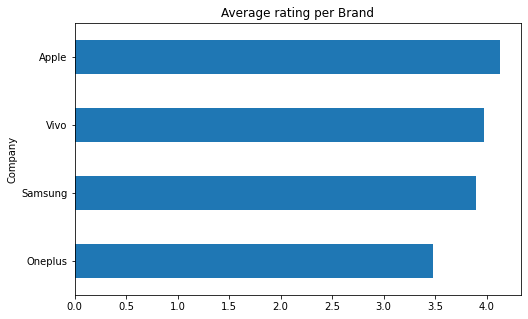

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
# Average rating per brand
ax = result.groupby("Company").mean()["Rating"].sort_values().plot(kind="barh",
                                                                figsize=(8,5), 
                                                                title="Average rating per Brand")
plt.show()


**Visualising Count of Sentiment according to Ratings of Different Companies**

Text(0.5, 1.0, 'Count of Moods')

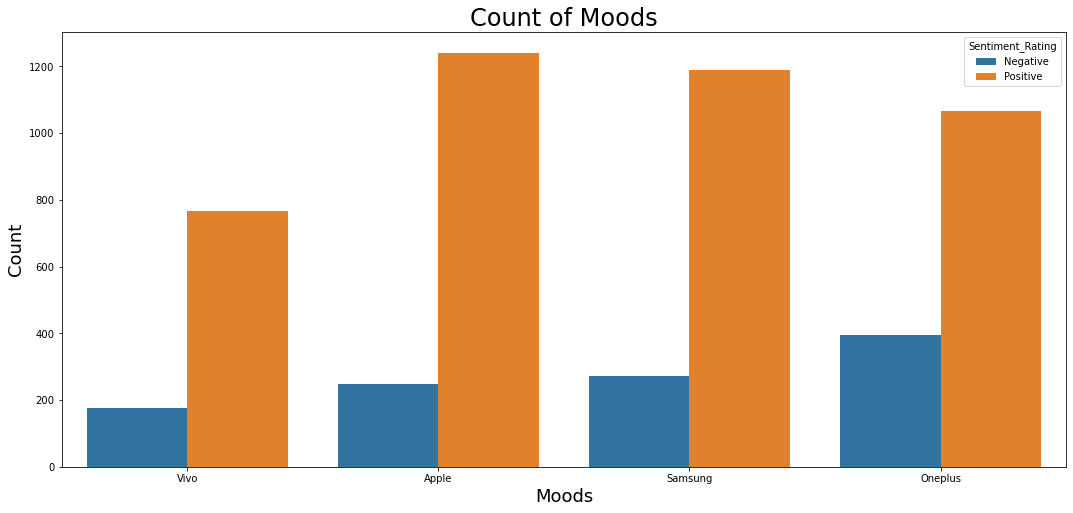

In [83]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'Company', hue = 'Sentiment_Rating', data = result)
plt.xlabel('Moods', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('Count of Moods', fontsize = 24)

Segregating the result DataFrame into Comapny wise DataFrame.

In [84]:
Op=result[result['Company']=='Oneplus']
Ip=result[result['Company']=='Apple']
Vivo=result[result['Company']=='Vivo']
Samsung=result[result['Company']=='Samsung']

Joining all Positive and Negative reviews for counting Bigrams frequencies. 

In [85]:
Op_pos=' '.join(Op[(Op['Sentiment_Rating']=='Positive')]['Comment'])
Ip_pos=' '.join(Ip[(Ip['Sentiment_Rating']=='Positive')]['Comment'])
Ip_neg=' '.join(Ip[(Ip['Sentiment_Rating']=='Negative')]['Comment'])
Op_neg=' '.join(Op[(Op['Sentiment_Rating']=='Negative')]['Comment'])
Vivo_pos=' '.join(Vivo[(Vivo['Sentiment_Rating']=='Positive')]['Comment'])
Sam_pos=' '.join(Samsung[(Samsung['Sentiment_Rating']=='Positive')]['Comment'])
Vivo_neg=' '.join(Vivo[(Vivo['Sentiment_Rating']=='Negative')]['Comment'])
Sam_neg=' '.join(Samsung[(Samsung['Sentiment_Rating']=='Negative')]['Comment'])
result_pos=' '.join(result[result['Sentiment_Rating']=='Positive']['Comment'])
result_neg=' '.join(result[result['Sentiment_Rating']=='Negative']['Comment'])

**WORDCLOUD of Bigrams using Bigram_Frequency**

In [86]:
#  Create Bigram_frequency Dictionary.
from wordcloud import WordCloud, ImageColorGenerator
def word_freq_dict(text):
    # Convert text into word list
    stopwords=['amazon','oneplus','iphone','apple','vivo','samsung','plus','nord','phone','mobile','good']
    wordList=text.split()
    wordList=[word for word in wordList if word not in stopwords]
    bigram=nltk.bigrams(wordList)
    fdist = nltk.FreqDist(bigram)
    # Generate bigram freq dictionary
    wordFreqDict={k[0]+' '+k[1]:v for k,v in fdist.items()}
    return wordFreqDict


In [87]:
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [88]:
# Define a function to plot top15 positive words and top15 negative words in a grouped bar plot (from dictionaries)
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title1, title2,palette1,palette2,Org,height=10):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    df_pos['Company']=Org
    df_pos.reset_index(inplace=True)
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    df_neg['Company']=Org
    df_neg.reset_index(inplace=True)
    # Plot
    print(df_pos)
    sns.catplot(x="index", y="frequency", hue="label", data=df_pos, 
                kind="bar",
                palette=palette1,
                height=height,aspect=2,
                legend_out=True)
    plt.title(title1+Org)
    plt.show()
    print(df_neg)
    sns.catplot(x="index", y="frequency", hue="label", data=df_neg, 
                kind="bar",
                palette=palette2,
                height=height,aspect=2,
                legend_out=True)
    plt.title(title2+Org)
    plt.show()
    return df_pos,df_neg

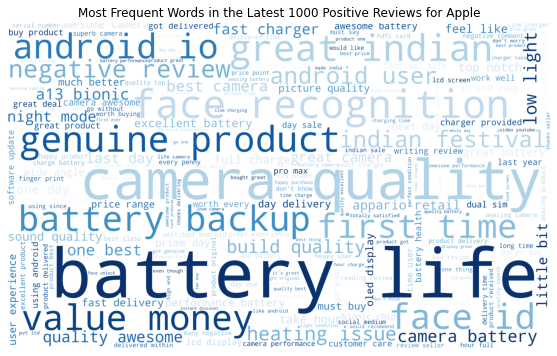

In [89]:
# Plot wordclouds for latest 1000 reviews for Apple
Ip_pos_word_freq = word_freq_dict(Ip_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(Ip_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Apple")

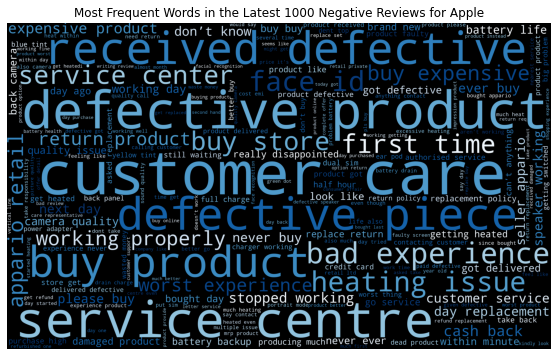

In [90]:
# Plot wordclouds for latest 1000 negativereviews for Apple
Ip_neg_word_freq = word_freq_dict(Ip_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="Black")
wordcloud_from_frequency(Ip_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Apple")

               index  frequency     label Company
0       battery life      0.168  Positive   Apple
1     camera quality      0.105  Positive   Apple
2   face recognition      0.045  Positive   Apple
3       great indian      0.039  Positive   Apple
4    genuine product      0.037  Positive   Apple
5        value money      0.036  Positive   Apple
6            face id      0.035  Positive   Apple
7     battery backup      0.035  Positive   Apple
8         android io      0.034  Positive   Apple
9         first time      0.032  Positive   Apple
10   negative review      0.031  Positive   Apple
11      android user      0.028  Positive   Apple
12   indian festival      0.027  Positive   Apple
13     heating issue      0.025  Positive   Apple
14     build quality      0.023  Positive   Apple


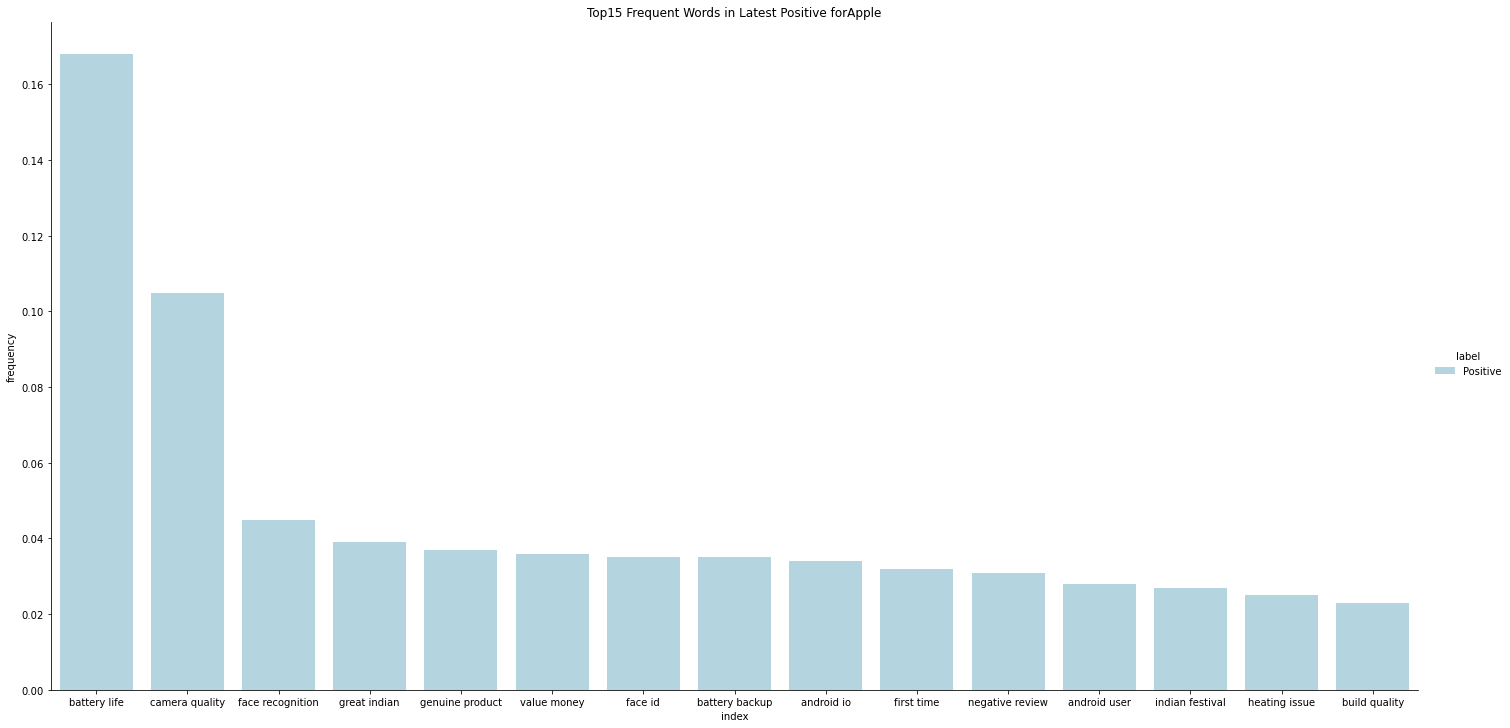

                 index  frequency     label Company
0        customer care   0.084337  Negative   Apple
1    defective product   0.060241  Negative   Apple
2       service centre   0.056225  Negative   Apple
3   received defective   0.044177  Negative   Apple
4      defective piece   0.044177  Negative   Apple
5          buy product   0.040161  Negative   Apple
6       bad experience   0.040161  Negative   Apple
7              face id   0.036145  Negative   Apple
8        heating issue   0.036145  Negative   Apple
9            buy store   0.032129  Negative   Apple
10      service center   0.032129  Negative   Apple
11          first time   0.032129  Negative   Apple
12    worst experience   0.028112  Negative   Apple
13       buy expensive   0.028112  Negative   Apple
14    working properly   0.028112  Negative   Apple


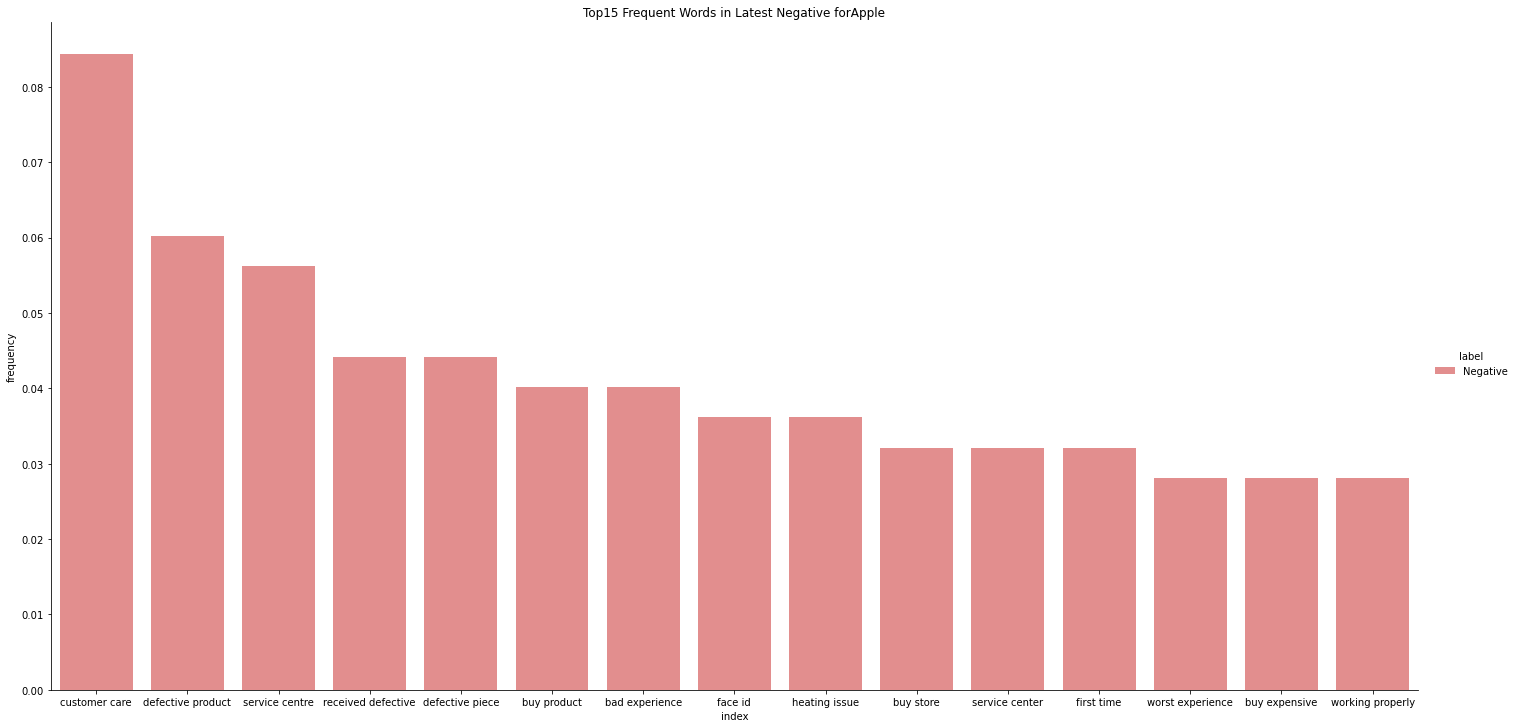

In [91]:
#Plotting top 15 positive and negative words for Apple
Apple_top_pos,Apple_top_neg=topn_wordfreq_bar_both(Ip_pos_word_freq, Ip_neg_word_freq, 
                       min(sum(Ip['Sentiment_Rating']=='Positive'), 1000), 
                       min(sum(Ip['Sentiment_Rating']=='Negative'), 1000), 
                       15, 
                       "Top15 Frequent Words in Latest Positive for","Top15 Frequent Words in Latest Negative for",["lightblue"],["lightcoral"],   
                       "Apple",height=10)

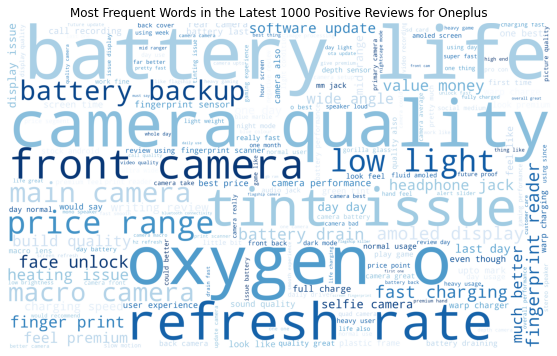

In [92]:
# Plot wordclouds for latest 1000 positive reviews for Oneplus
Op_pos_word_freq = word_freq_dict(Op_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(Op_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Oneplus")

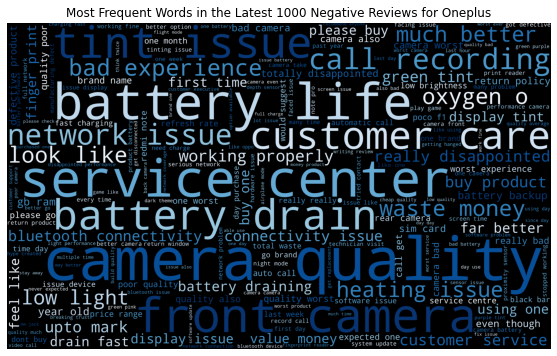

In [93]:
# Plot wordclouds for latest 1000 negativereviews for Oneplus
Op_neg_word_freq = word_freq_dict(Op_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="Black")
wordcloud_from_frequency(Op_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Oneplus")

                 index  frequency     label  Company
0         battery life      0.191  Positive  Oneplus
1             oxygen o      0.165  Positive  Oneplus
2       camera quality      0.152  Positive  Oneplus
3           tint issue      0.093  Positive  Oneplus
4         refresh rate      0.089  Positive  Oneplus
5         front camera      0.082  Positive  Oneplus
6          price range      0.076  Positive  Oneplus
7            low light      0.072  Positive  Oneplus
8          main camera      0.058  Positive  Oneplus
9       battery backup      0.056  Positive  Oneplus
10        macro camera      0.052  Positive  Oneplus
11      amoled display      0.051  Positive  Oneplus
12  fingerprint reader      0.049  Positive  Oneplus
13       fast charging      0.047  Positive  Oneplus
14         face unlock      0.046  Positive  Oneplus


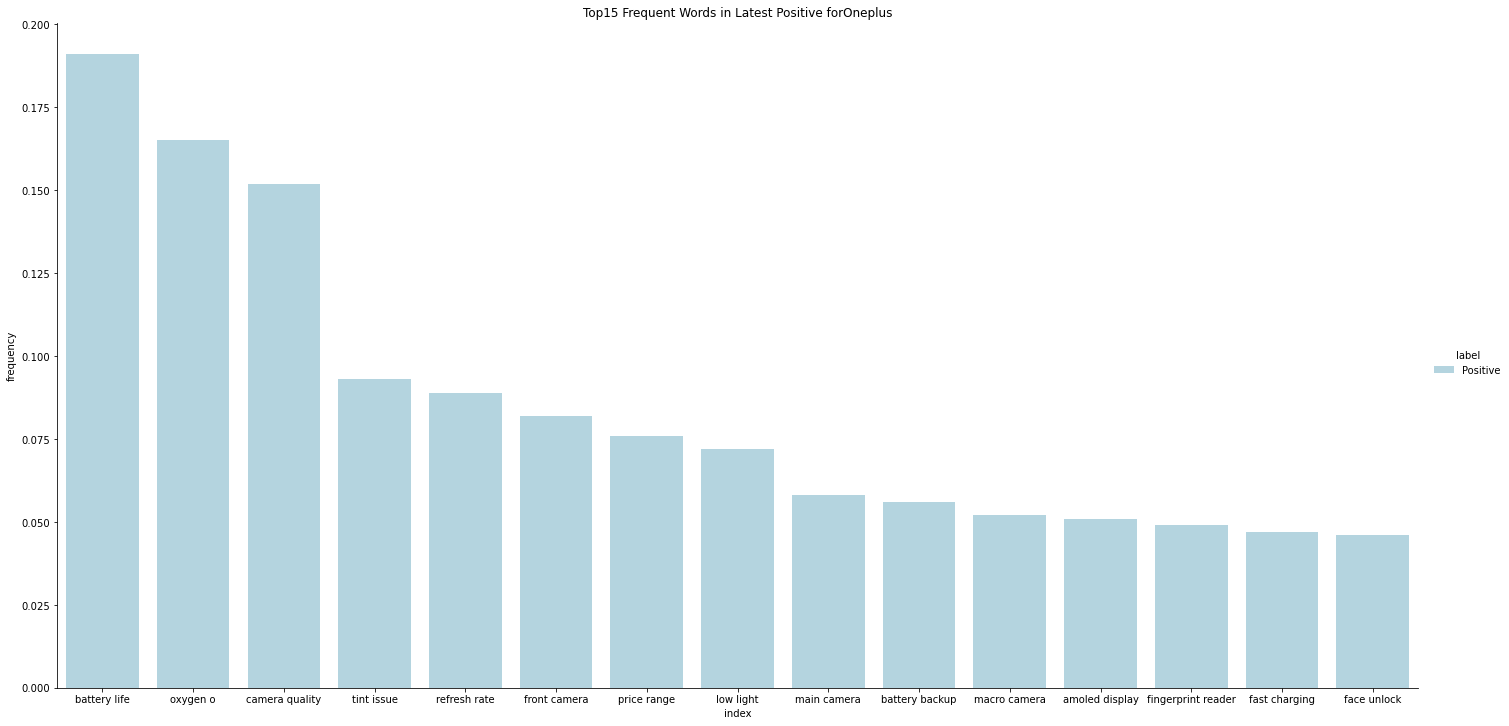

             index  frequency     label  Company
0   camera quality   0.119289  Negative  Oneplus
1   service center   0.086294  Negative  Oneplus
2     battery life   0.081218  Negative  Oneplus
3     front camera   0.073604  Negative  Oneplus
4       tint issue   0.060914  Negative  Oneplus
5    battery drain   0.055838  Negative  Oneplus
6    customer care   0.048223  Negative  Oneplus
7    network issue   0.043147  Negative  Oneplus
8   call recording   0.043147  Negative  Oneplus
9   bad experience   0.040609  Negative  Oneplus
10     waste money   0.038071  Negative  Oneplus
11        oxygen o   0.038071  Negative  Oneplus
12       look like   0.038071  Negative  Oneplus
13     much better   0.035533  Negative  Oneplus
14   heating issue   0.035533  Negative  Oneplus


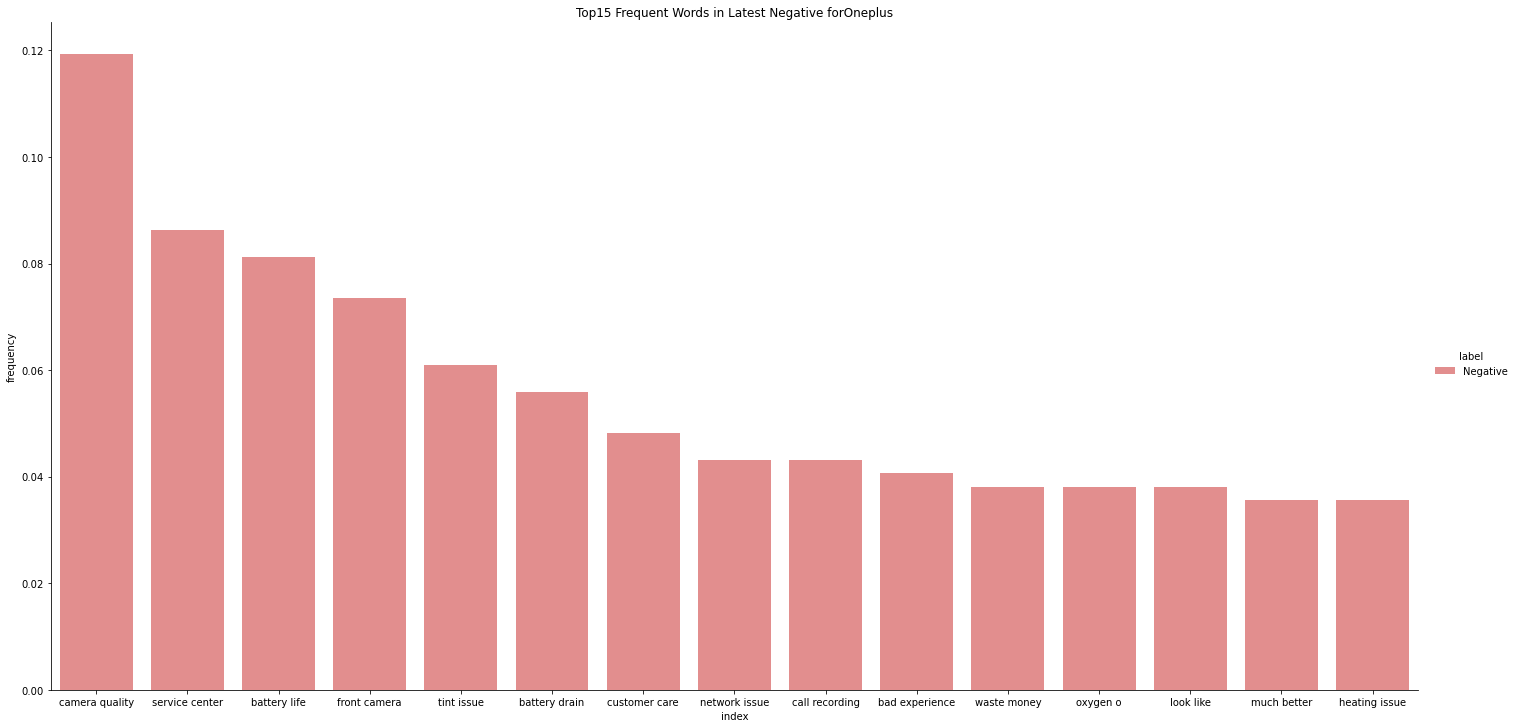

In [94]:
#Plotting top 15 positive and negative words for Oneplus
Op_top_pos,Op_top_neg=topn_wordfreq_bar_both(Op_pos_word_freq, Op_neg_word_freq, 
                       min(sum(Op['Sentiment_Rating']=='Positive'), 1000), 
                       min(sum(Op['Sentiment_Rating']=='Negative'), 1000), 
                       15, 
                       "Top15 Frequent Words in Latest Positive for","Top15 Frequent Words in Latest Negative for",["lightblue"],["lightcoral"], 
                       "Oneplus",height=10)

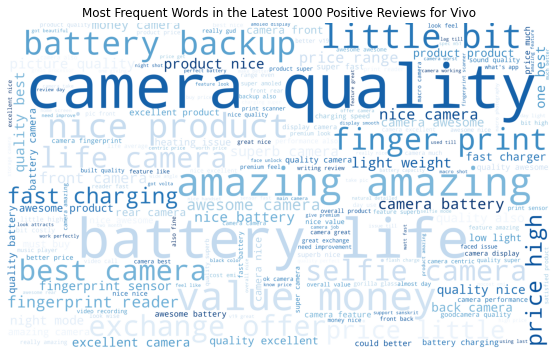

In [95]:
# Plot wordclouds for latest 1000 positive reviews for Vivo
Vivo_pos_word_freq = word_freq_dict(Vivo_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(Vivo_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Vivo")

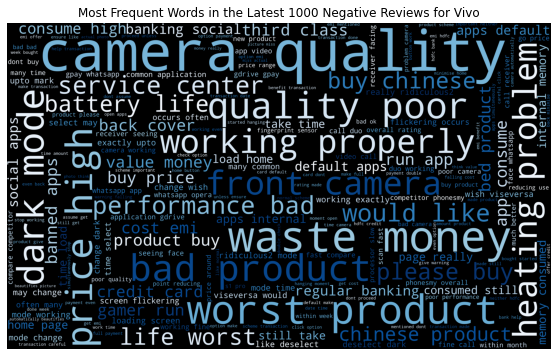

In [96]:
# Plot wordclouds for latest 1000 negativereviews for Vivo
Vivo_neg_word_freq = word_freq_dict(Vivo_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="Black")
wordcloud_from_frequency(Vivo_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Vivo")

                 index  frequency     label Company
0       camera quality   0.073203  Positive    Vivo
1         battery life   0.057516  Positive    Vivo
2          value money   0.026144  Positive    Vivo
3      amazing amazing   0.026144  Positive    Vivo
4         nice product   0.018301  Positive    Vivo
5           little bit   0.018301  Positive    Vivo
6       battery backup   0.016993  Positive    Vivo
7         finger print   0.014379  Positive    Vivo
8        selfie camera   0.013072  Positive    Vivo
9       exchange offer   0.013072  Positive    Vivo
10         life camera   0.013072  Positive    Vivo
11         best camera   0.013072  Positive    Vivo
12          price high   0.011765  Positive    Vivo
13       fast charging   0.011765  Positive    Vivo
14  fingerprint reader   0.011765  Positive    Vivo


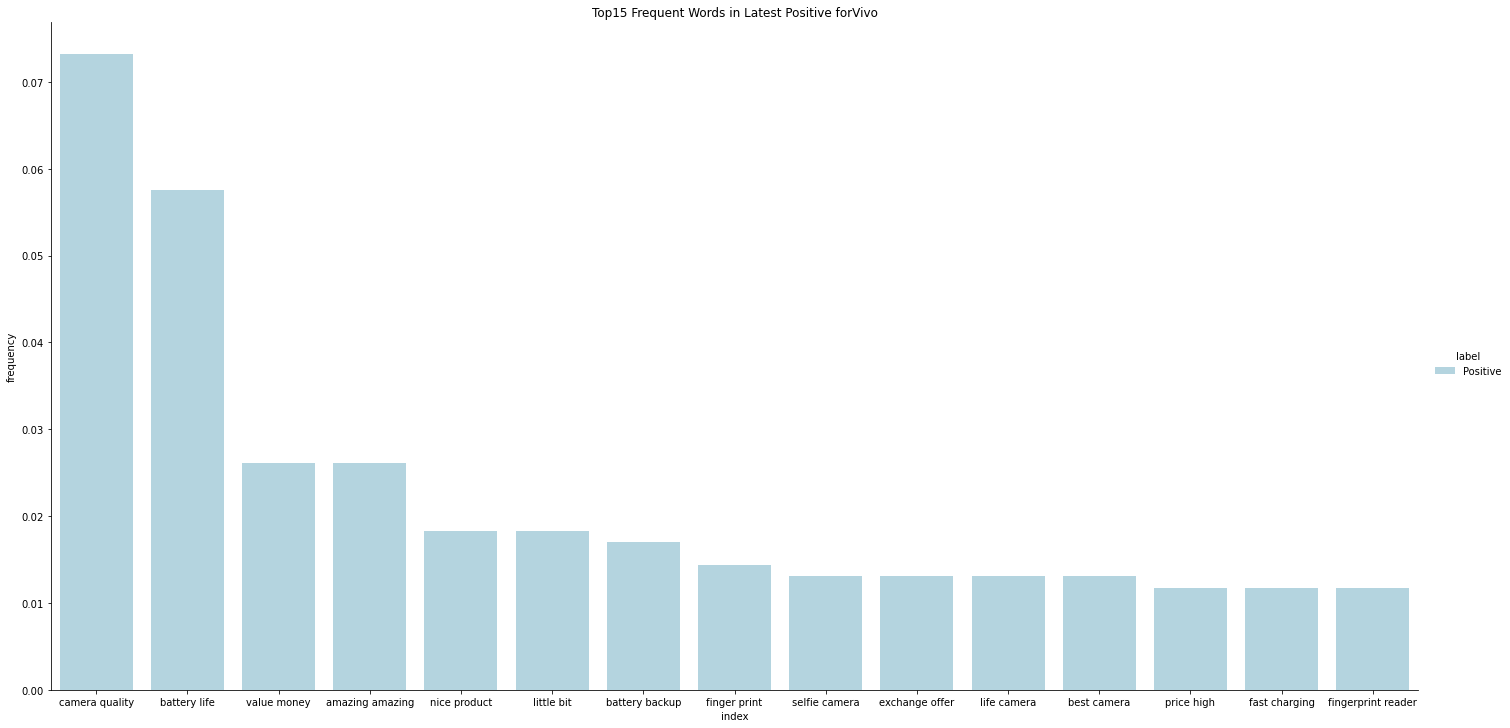

               index  frequency     label Company
0     camera quality   0.074286  Negative    Vivo
1        waste money   0.040000  Negative    Vivo
2      worst product   0.034286  Negative    Vivo
3        bad product   0.028571  Negative    Vivo
4          dark mode   0.028571  Negative    Vivo
5       quality poor   0.028571  Negative    Vivo
6         price high   0.028571  Negative    Vivo
7       front camera   0.022857  Negative    Vivo
8   working properly   0.022857  Negative    Vivo
9    heating problem   0.022857  Negative    Vivo
10       buy chinese   0.017143  Negative    Vivo
11        would like   0.017143  Negative    Vivo
12    service center   0.017143  Negative    Vivo
13        please buy   0.017143  Negative    Vivo
14   performance bad   0.017143  Negative    Vivo


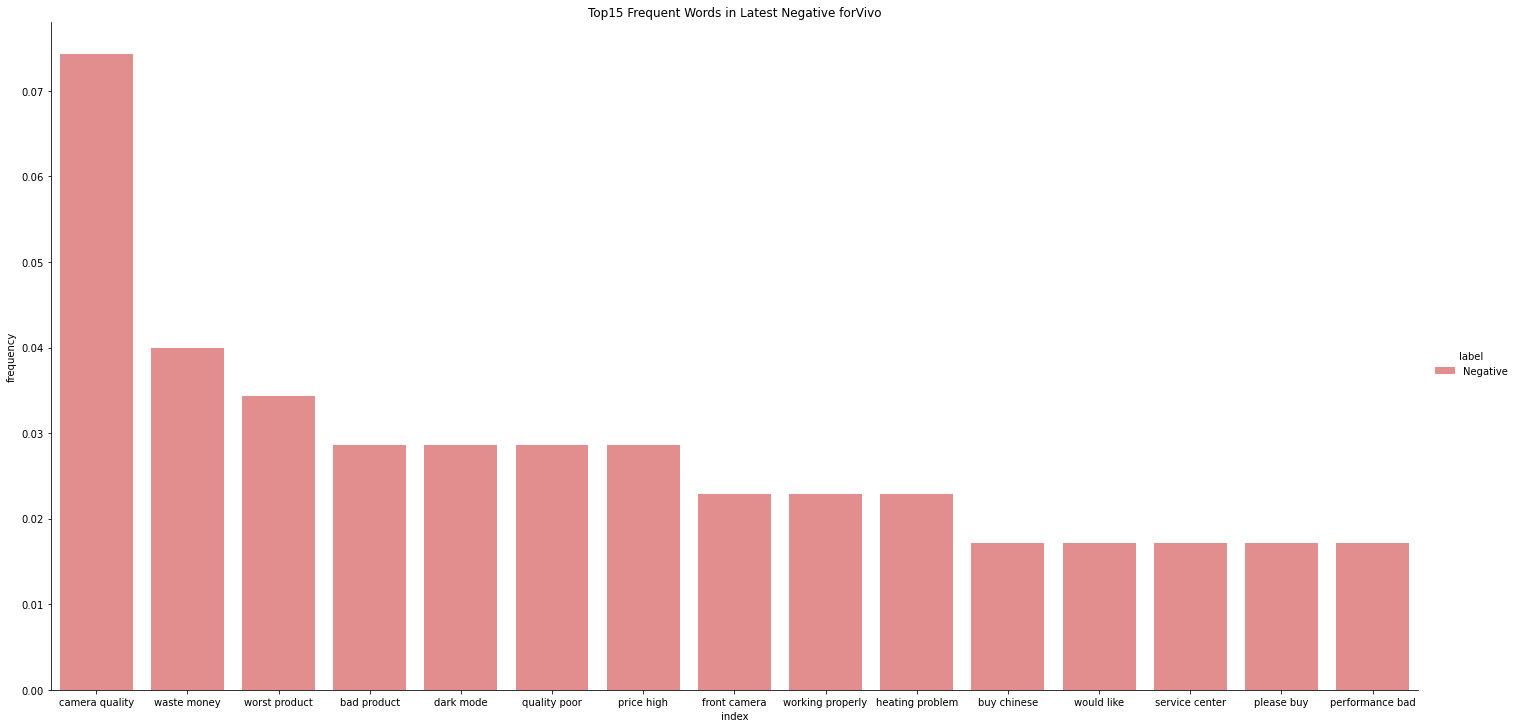

In [97]:
#Plotting top 15 positive and negative words for Vivo
Vivo_top_pos,Vivo_top_neg=topn_wordfreq_bar_both(Vivo_pos_word_freq, Vivo_neg_word_freq, 
                       min(sum(Vivo['Sentiment_Rating']=='Positive'), 1000), 
                       min(sum(Vivo['Sentiment_Rating']=='Negative'), 1000), 
                       15, 
                       "Top15 Frequent Words in Latest Positive for","Top15 Frequent Words in Latest Negative for",["lightblue"],["lightcoral"],
                       "Vivo",height=10)

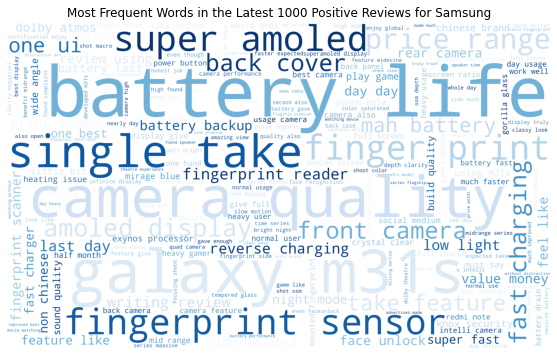

In [98]:
# Plot wordclouds for latest 1000 positive reviews for Samsung
Sam_pos_word_freq = word_freq_dict(Sam_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(Sam_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

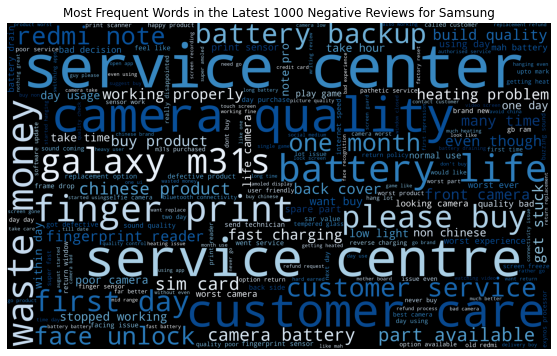

In [99]:
# Plot wordclouds for latest 1000 negativereviews for Samsung
Sam_neg_word_freq = word_freq_dict(Sam_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="Black")
wordcloud_from_frequency(Sam_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")

                 index  frequency     label  Company
0         battery life      0.287  Positive  Samsung
1          galaxy m31s      0.207  Positive  Samsung
2       camera quality      0.185  Positive  Samsung
3          single take      0.155  Positive  Samsung
4   fingerprint sensor      0.124  Positive  Samsung
5         super amoled      0.123  Positive  Samsung
6         finger print      0.121  Positive  Samsung
7          price range      0.115  Positive  Samsung
8       amoled display      0.109  Positive  Samsung
9           back cover      0.098  Positive  Samsung
10        front camera      0.097  Positive  Samsung
11       fast charging      0.097  Positive  Samsung
12         mah battery      0.085  Positive  Samsung
13        take feature      0.085  Positive  Samsung
14              one ui      0.084  Positive  Samsung


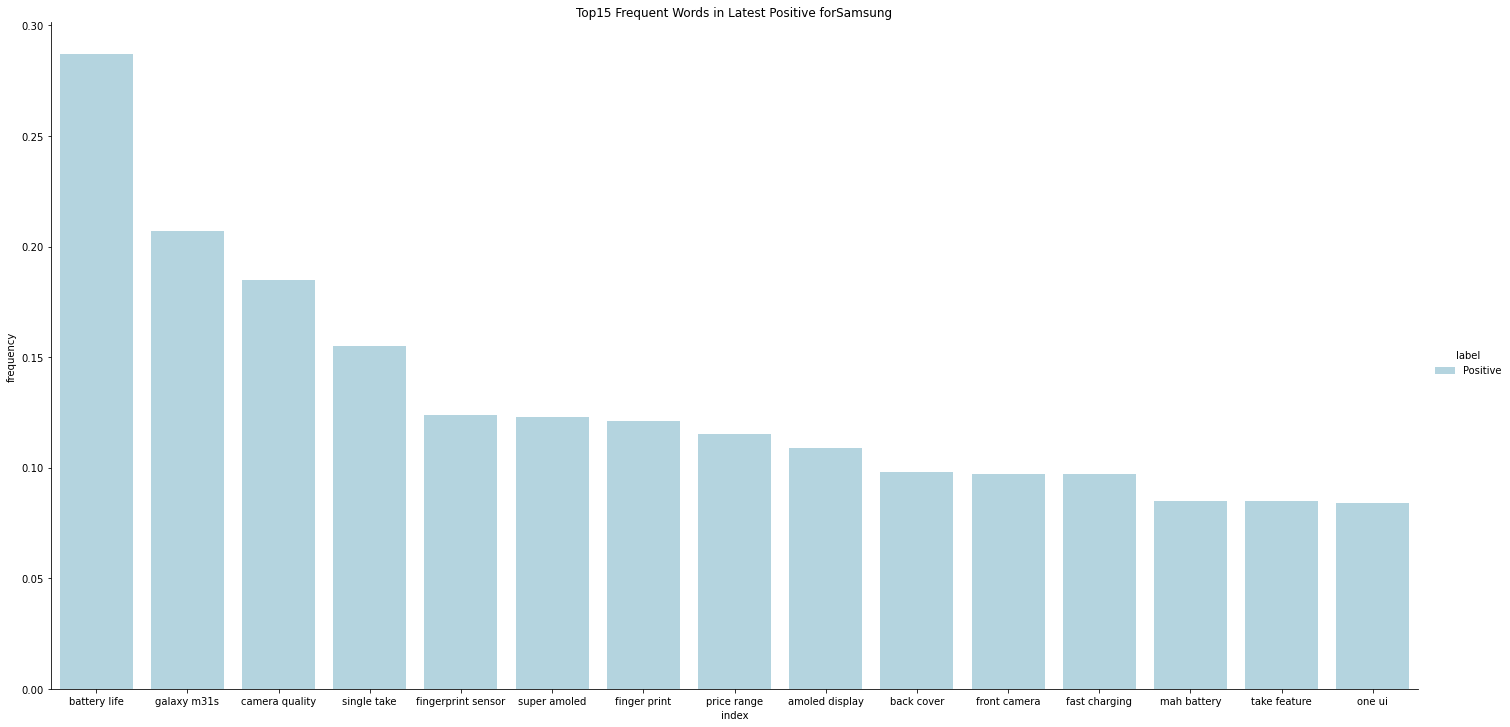

               index  frequency     label  Company
0     service center   0.154982  Negative  Samsung
1     service centre   0.114391  Negative  Samsung
2     camera quality   0.095941  Negative  Samsung
3      customer care   0.088561  Negative  Samsung
4       battery life   0.055351  Negative  Samsung
5        waste money   0.055351  Negative  Samsung
6       finger print   0.051661  Negative  Samsung
7        galaxy m31s   0.047970  Negative  Samsung
8     battery backup   0.036900  Negative  Samsung
9         please buy   0.036900  Negative  Samsung
10  customer service   0.036900  Negative  Samsung
11         first day   0.036900  Negative  Samsung
12         one month   0.033210  Negative  Samsung
13       face unlock   0.033210  Negative  Samsung
14        redmi note   0.033210  Negative  Samsung


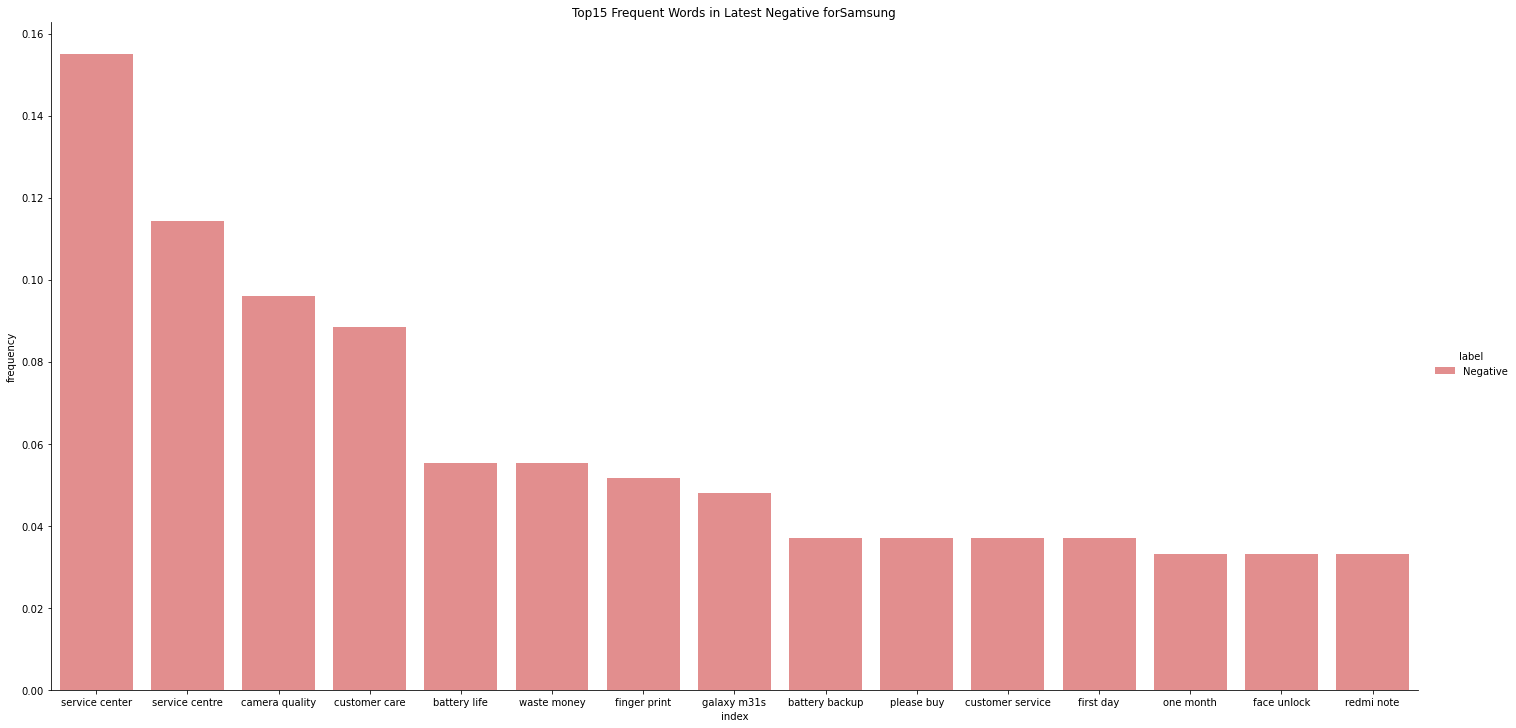

In [100]:
#Plotting top 15 positive and negative words for Samsung
Sam_top_pos,Sam_top_neg=topn_wordfreq_bar_both(Sam_pos_word_freq, Sam_neg_word_freq, 
                       min(sum(Samsung['Sentiment_Rating']=='Positive'), 1000), 
                       min(sum(Samsung['Sentiment_Rating']=='Negative'), 1000), 
                       15, 
                       "Top15 Frequent Words in Latest Positive for","Top15 Frequent Words in Latest Negative for",["lightblue"],["lightcoral"],
                       "Samsung",height=10)

In [101]:
#finding common bigrams in top15 Positive and Negative reviews of All Companies.
common_values_neg = set.intersection(set(Op_top_neg['index']), set(Apple_top_neg['index']), set(Vivo_top_neg['index']), set(Sam_top_neg['index']))
common_values_pos=set.intersection(set(Op_top_pos['index']), set(Apple_top_pos['index']), set(Vivo_top_pos['index']), set(Sam_top_pos['index']))

In [102]:
common_values_neg

{'service center'}

In [103]:
common_values_pos

{'battery life', 'camera quality'}

In [104]:
Common_bigrams_neg = pd.concat([Op_top_neg[Op_top_neg['index'].isin(common_values_neg)], Apple_top_neg[Apple_top_neg['index'].isin(common_values_neg)], Vivo_top_neg[Vivo_top_neg['index'].isin(common_values_neg)],Sam_top_neg[Sam_top_neg['index'].isin(common_values_neg)]], ignore_index=True)
Common_bigrams_pos = pd.concat([Op_top_pos[Op_top_pos['index'].isin(common_values_pos)], Apple_top_pos[Apple_top_pos['index'].isin(common_values_pos)], Vivo_top_pos[Vivo_top_pos['index'].isin(common_values_pos)],Sam_top_pos[Sam_top_pos['index'].isin(common_values_pos)]], ignore_index=True)

In [105]:
Common_bigrams_neg.sort_values("frequency" ,axis = 0, ascending = False, 
                 inplace = True, na_position ='last')
Common_bigrams_neg

,index,frequency,label,Company
3,service center,0.154982,Negative,Samsung
0,service center,0.086294,Negative,Oneplus
1,service center,0.032129,Negative,Apple
2,service center,0.017143,Negative,Vivo


In [106]:
Common_bigrams_pos.sort_values(["index","frequency"] ,axis = 0, ascending = False, 
                 inplace = True, na_position ='last')
Common_bigrams_pos

,index,frequency,label,Company
7,camera quality,0.185000,Positive,Samsung
1,camera quality,0.152000,Positive,Oneplus
3,camera quality,0.105000,Positive,Apple
4,camera quality,0.073203,Positive,Vivo
6,battery life,0.287000,Positive,Samsung
0,battery life,0.191000,Positive,Oneplus
2,battery life,0.168000,Positive,Apple
5,battery life,0.057516,Positive,Vivo


Text(0.5, 1.0, 'Frequency of common Negative features of different companies')

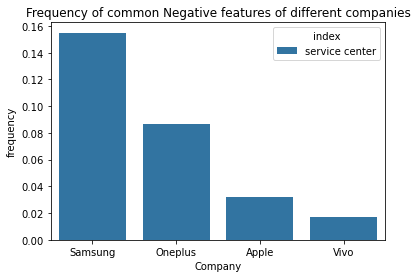

In [107]:
#Common Negative Features 
 # Draw a nested barplot of common negative features of different companies.
ax = sns.barplot(x="Company", y="frequency", hue="index", data=Common_bigrams_neg)
plt.title("Frequency of common Negative features of different companies")

Text(0.5, 1.0, 'Frequency of common Positive features of different companies')

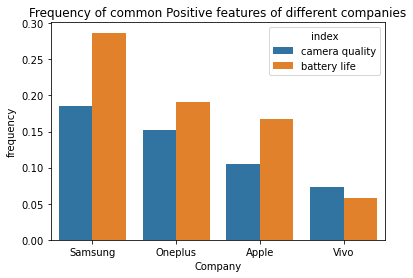

In [108]:
#Common Negative Features 
 # Draw a nested barplot of common positive features of different companies.
ax = sns.barplot(x="Company", y="frequency", hue="index", data=Common_bigrams_pos)
plt.title("Frequency of common Positive features of different companies")

# SENTIMENT ANALYSIS USING Naive Bayes

In [109]:
#Covert Sentiment into Binary Classification of format('-1': Negative,'1' :Positive)
sent_dict = {'Positive':1, 'Negative':-1}
for key, value in sent_dict.items():
    result['Sentiment_Rating'] = result['Sentiment_Rating'].replace(key, value)
result

,index,Name,Title,Rating,Comment,Company,Sentiment_Textblob_Comment,Sentiment_Textblob_Title,Sentiment_Rating
0,0,ajith,cost emi offer amazon,1,rating made product give warning falling cost ...,Vivo,Positive,Positive,-1
1,1,Wasim Shaikh,stylish best camera phone,4,honest reviewif hard core gammer happy mobile1...,Vivo,Positive,Positive,1
2,2,suresh.p,browser hangingwaste product,3,worst product browser hanging eate moneyo supp...,Vivo,Negative,Negative,1
3,3,Ravi Keshri,wasted buck feel like cheated vivo,1,week bought phone started hanging moment open ...,Vivo,Positive,Negative,-1
4,4,voocha madhu babu,worst security,1,hi really concerned security phone data device...,Vivo,Positive,Negative,-1
...,...,...,...,...,...,...,...,...,...
5345,1455,!,best phone,5,bloody good productone plus finally understood...,Oneplus,Positive,Positive,1
5346,1456,Souvik,one best overall midsegment smartphone,5,well midsegment smartphone definitely setback ...,Oneplus,Positive,Positive,1
5347,1457,User123,call issue defected microphone,1,call completed around call failrecipient unabl...,Oneplus,Negative,Negative,-1
5348,1458,Rajkannu nataraj,worth product,4,awesome productcamera quality good especially ...,Oneplus,Positive,Positive,1


In [110]:
#Create Bag of Words Model 
X=result['Comment']
y=result['Sentiment_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
vectorizer=CountVectorizer()
BOW=vectorizer.fit_transform(X_train)
df=pd.DataFrame(BOW.toarray(),columns=vectorizer.get_feature_names())

In [111]:
count=result['Sentiment_Rating'].value_counts()
print(count)

 1    4261
-1    1089
Name: Sentiment_Rating, dtype: int64


In [112]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(BOW, y_train)

In [113]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(-1, 3411), (1, 3411)]


In [114]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.8803869832893579

In [115]:
X_test_vect = vectorizer.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array([-1,  1,  1, ...,  1,  1, -1], dtype=int64)

In [116]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 86.73%

F1 Score: 91.67

COnfusion Matrix:
 [[147  73]
 [ 69 781]]
